In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from math import sqrt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from random import sample
from pandas import DataFrame
from numpy import random
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from pandas import Series
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from scipy.stats import skew
from scipy.stats import kurtosis
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro

  ## What is the The Big 5 Personality Traits?
  
The Big Five personality traits is a suggested taxonomy, or grouping, for personality traits, developed from the 1980s onward in psychological trait theory.
Starting in the 1990s, the theory identified five factors by labels, for the US English speaking population, typically referred to as:


* openness to experience (inventive/curious vs. consistent/cautious)

* conscientiousness (efficient/organized vs. extravagant/careless)

* extraversion (outgoing/energetic vs. solitary/reserved)

* agreeableness (friendly/compassionate vs. critical/rational)

* neuroticism (sensitive/nervous vs. resilient/confident)


([Vikipedia](http://))


A video that simply explains the big five factor theory. [Youtube](https://youtu.be/IB1FVbo8TSs)


 In that data have a 50 personality test question, partipiansts location, screen size and time information. I will analyze the data and then find the  participants clusters. 

1. Data pre-processing

  1.1 Missing Values And Data Cleaning
  
  1.2 Skew And Kurtosis Analysis
  
  1.3 Outlier(IQR)
  
  1.4 Standardization

  1.5 PCA
 
2. Model

   1.1 K-means
   
   1.2 GMM(Gaussian Mixture Model)

3. Results
  

### 1. Data pre-processing

In [ ]:
df = pd.read_csv('data-final.csv', delimiter='\t')
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [ ]:
df.EST5 = 6 - df.EST5.values
df.EST6 = 6 - df.EST6.values
df.OPN1 = 6 - df.OPN1.values

In [ ]:
#Some time columns are milisecond, so i will convert them to second.
df.iloc[:, 50:100] = df.iloc[:, 50:100].divide(1000, axis = 'rows')

#### 1.1 Missing Values

In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
missing_value_df

,column_name,percent_missing
introelapse,introelapse,0.203478
screenh,screenh,0.203478
screenw,screenw,0.203478
EXT1,EXT1,0.175606
EST6_E,EST6_E,0.175606
...,...,...
dateload,dateload,0.000000
endelapse,endelapse,0.000000
IPC,IPC,0.000000
lat_appx_lots_of_err,lat_appx_lots_of_err,0.000000


In [ ]:
# The missing value seems less because this dataset is really big. So I decided to drop all missing values.
df = df.dropna()
df.isnull().sum().any()

False

In [ ]:
# There can be multiple submissions from the same IP address. If the IP value is more than one, being recommended to delete it.
df.drop(df.index[df['IPC'] != 1], inplace = True)
df['IPC'].describe()

count    694886.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: IPC, dtype: float64

In [ ]:
df.drop(['IPC','screenh','screenw'],axis=1,inplace= True)
df.shape

(694886, 107)

In [ ]:
Location = pd.DataFrame(df['country'])

In [ ]:
# I am removing non-numeric columns.
df.drop(['country','long_appx_lots_of_err','lat_appx_lots_of_err','dateload'],axis=1,inplace= True)

In [ ]:
# I've seen in some answers that there are 0 values but it shouldn't be like that. Answers should be between 1-5.
df =df[(df > 0).all(1)]

In [ ]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,introelapse,testelapse,endelapse
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,3.411,2.170,4.920,4.436,3.116,2.992,4.354,9.0,234.0,6
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,3.026,4.742,3.336,2.718,3.374,3.096,3.019,12.0,179.0,11
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,1.683,2.229,8.114,2.043,6.295,1.585,2.529,3.0,186.0,7
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,3.728,4.128,3.776,2.984,4.192,3.480,3.257,186.0,219.0,7
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,4.352,2.681,3.272,2.640,1.568,1.640,3.192,4.0,196.0,3


In [ ]:
question_df = (df.iloc[:, 0:50])
question_df

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,1.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,5.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,1.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,1.0,1.0,5.0,1.0,3.0,1.0,5.0,4.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015334,4.0,1.0,4.0,2.0,4.0,3.0,3.0,2.0,3.0,2.0,...,3.0,3.0,5.0,3.0,4.0,2.0,5.0,2.0,3.0,4.0
1015335,5.0,1.0,5.0,2.0,4.0,2.0,3.0,1.0,5.0,1.0,...,2.0,1.0,4.0,2.0,3.0,2.0,5.0,3.0,4.0,4.0
1015337,4.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,...,2.0,1.0,5.0,1.0,5.0,1.0,3.0,4.0,5.0,4.0
1015339,2.0,4.0,3.0,4.0,2.0,2.0,1.0,4.0,2.0,4.0,...,1.0,2.0,4.0,2.0,3.0,2.0,4.0,5.0,5.0,3.0


In [ ]:
col_list = list(df)
ext = ['EXT1','EXT3','EXT5','EXT7','EXT9']
ınt = ['EXT2','EXT4','EXT6','EXT6','EXT10']
opn = ['OPN3','OPN5','OPN7','OPN8','OPN9','OPN10']
cst = ['OPN1','OPN2','OPN4','OPN6']
agr = ['AGR2','AGR4','AGR6','AGR8','AGR10','AGR9']
cpt = ['AGR1','AGR3','AGR5','AGR7']
csn = ['CSN1','CSN3','CSN5','CSN7','CSN9','CSN10']
spt = ['CSN2','CSN4','CSN6','CSN8']
est = ['EST2','EST4','EST5','EST6']
nrt = ['EST1','EST3','EST7','EST8','EST9','EST10']


df['extroversion'] = df[ext].sum(axis=1)
df['introversion'] = df[ınt].sum(axis=1)
df['open'] = df[opn].sum(axis=1)
df['consistency'] = df[cst].sum(axis=1)
df['agreeable'] = df[agr].sum(axis=1)
df['competitiveness'] = df[cpt].sum(axis=1)
df['conscientious'] = df[csn].sum(axis=1)
df['spontaneity'] = df[spt].sum(axis=1)
df['emotionally_stable'] = df[est].sum(axis=1)
df['neurotic'] = df[nrt].sum(axis=1)

In [ ]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,extroversion,introversion,open,consistency,agreeable,competitiveness,conscientious,spontaneity,emotionally_stable,neurotic
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,23.0,6.0,25.0,4.0,23.0,8.0,20.0,12.0,14.0,14.0
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,12.0,20.0,21.0,10.0,26.0,6.0,22.0,9.0,12.0,13.0
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,12.0,16.0,22.0,5.0,23.0,5.0,19.0,9.0,14.0,16.0
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,11.0,13.0,22.0,7.0,23.0,9.0,14.0,13.0,12.0,17.0
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,16.0,13.0,24.0,4.0,21.0,7.0,21.0,8.0,15.0,13.0


In [ ]:
df.drop(df.columns[0:50], axis=1, inplace=True)
df.head()

,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,...,extroversion,introversion,open,consistency,agreeable,competitiveness,conscientious,spontaneity,emotionally_stable,neurotic
0,9.419,5.491,3.959,4.821,5.611,2.756,2.388,2.113,5.900,4.110,...,23.0,6.0,25.0,4.0,23.0,8.0,20.0,12.0,14.0,14.0
1,7.235,3.598,3.315,2.564,2.976,3.050,4.787,3.228,3.465,3.309,...,12.0,20.0,21.0,10.0,26.0,6.0,22.0,9.0,12.0,13.0
2,4.657,3.549,2.543,3.335,5.847,2.540,4.922,3.142,14.621,2.191,...,12.0,16.0,22.0,5.0,23.0,5.0,19.0,9.0,14.0,16.0
3,3.996,2.896,5.096,4.240,5.168,5.456,4.360,4.496,5.240,4.000,...,11.0,13.0,22.0,7.0,23.0,9.0,14.0,13.0,12.0,17.0
5,4.834,5.064,1.160,2.664,6.711,3.344,2.512,6.264,6.992,4.592,...,16.0,13.0,24.0,4.0,21.0,7.0,21.0,8.0,15.0,13.0


#### 1.2 Skew Analysis

In [ ]:
#@title
skew_list= pd.DataFrame(df.skew())
skew_list.reset_index(inplace = True)
skew_list
skew_list.rename(columns={"index": "Column", 0: "Skew"},inplace=True)

result = []
for i in skew_list["Skew"]:
    if -0.5 < i < 0.5 :
        result.append("symmetrical")
    if -1 < i < -0.5  :
        result.append("positive slightly_skewed")
    if 0.5 < i < 1  :
        result.append("negative slightly_skewed")
    if -1 > i:
        
        
        
        result.append("negative skewed")
    if  1 < i:
        result.append("positive skewed")
skew_list["Result"] = result
skew_label = list(skew_list["Result"].unique())
skew_list_values = list(skew_list["Result"].value_counts())

In [ ]:
skew_list

,Column,Skew,Result
0,EXT1_E,235.368913,positive skewed
1,EXT2_E,290.222848,positive skewed
2,EXT3_E,452.617006,positive skewed
3,EXT4_E,217.492084,positive skewed
4,EXT5_E,366.576387,positive skewed
...,...,...,...
58,competitiveness,0.593400,negative slightly_skewed
59,conscientious,-0.161364,symmetrical
60,spontaneity,0.096355,symmetrical
61,emotionally_stable,-0.002050,symmetrical


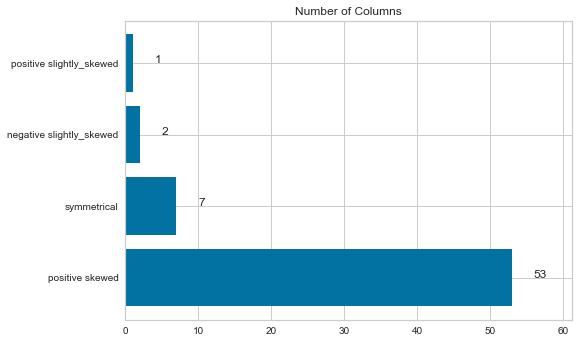

In [ ]:
#@title
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [8,4]
plt.title("Number of Columns")

ax.barh(skew_label, skew_list_values)
for i, value in enumerate(skew_list_values):
    ax.text(value + 3, i, str(value))
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, 1.1*xmax)
plt.show()


In [ ]:
#@title
kurtosis_list = pd.DataFrame(df.kurtosis())
kurtosis_list.reset_index(inplace = True)
kurtosis_list.rename(columns={"index": "Column", 0: "kurtosis"},inplace=True)

result = []
for i in kurtosis_list["kurtosis"]:
    if i >3 :
        result.append("leptokurtic")
    if i <3:
        result.append("platykurtic")
    if i ==3:
        result.append("mesokurtic")
kurtosis_list["Result"] = result

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

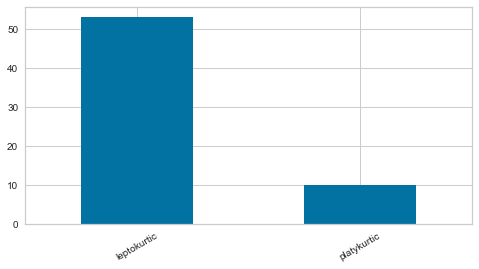

In [ ]:
kurtosis_list["Result"].value_counts().plot(kind='bar')
plt.xticks(rotation=30)

In [ ]:
positive = skew_list[skew_list['Result'].str.contains("positive")]
negative = skew_list[skew_list['Result'].str.contains("negative")]
p = list(positive["Column"].values)
n = list(negative["Column"].values)

In [ ]:
# Box Cox For Posivite Skew
from scipy import stats 
for i in p:
    a, b = stats.boxcox(df[i])
    df[i] = a

In [ ]:
# Square Root For Negative Skew
for i in n:
    df[i] = np.sqrt((df[i]))

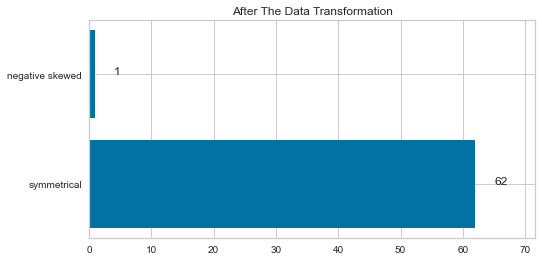

In [ ]:
#@title
skew_list= pd.DataFrame(df.skew())
skew_list.reset_index(inplace = True)
skew_list
skew_list.rename(columns={"index": "Column", 0: "Skew"},inplace=True)

result = []
for i in skew_list["Skew"]:
    if -0.5 < i < 0.5 :
        result.append("symmetrical")
    if -1 < i < -0.5  :
        result.append("positive slightly_skewed")
    if 0.5 < i < 1  :
        result.append("negative slightly_skewed")
    if -1 > i:
        result.append("negative skewed")
    if  1 < i:
        result.append("positive skewed")
skew_list["Result"] = result

skew_label = list(skew_list["Result"].unique())
skew_list_values = list(skew_list["Result"].value_counts())

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [8,4]
plt.title("After The Data Transformation")

ax.barh(skew_label, skew_list_values)
for i, value in enumerate(skew_list_values):
    ax.text(value + 3, i, str(value))
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, 1.1*xmax)
plt.show()



In [ ]:
#@title
del skew_list

In [ ]:
df['time'] = df.iloc[:, 50:100].sum(axis=1)
df['time'] = (df['introelapse']  + df['endelapse'] + df['time'])/60
df.drop(['introelapse','endelapse','testelapse'],axis=1,inplace= True)
df.drop(df.columns[0:50], axis=1, inplace=True)

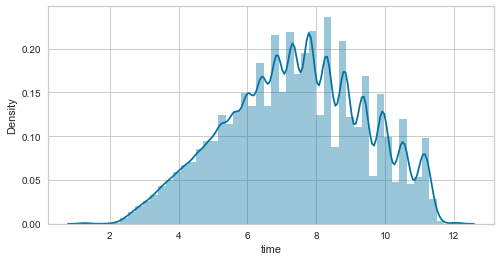

In [ ]:
#@title
sns.distplot(df['time'])

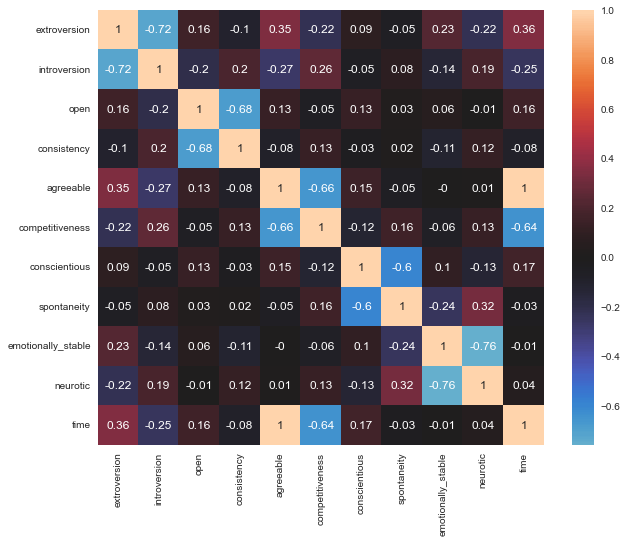

In [ ]:
# Now that the times have summed up, I'll take  look at the heatmap.
corrmat= df.corr().round(2)
plt.figure(figsize=(10,8))  
sns.heatmap(corrmat,annot=True,center=0)

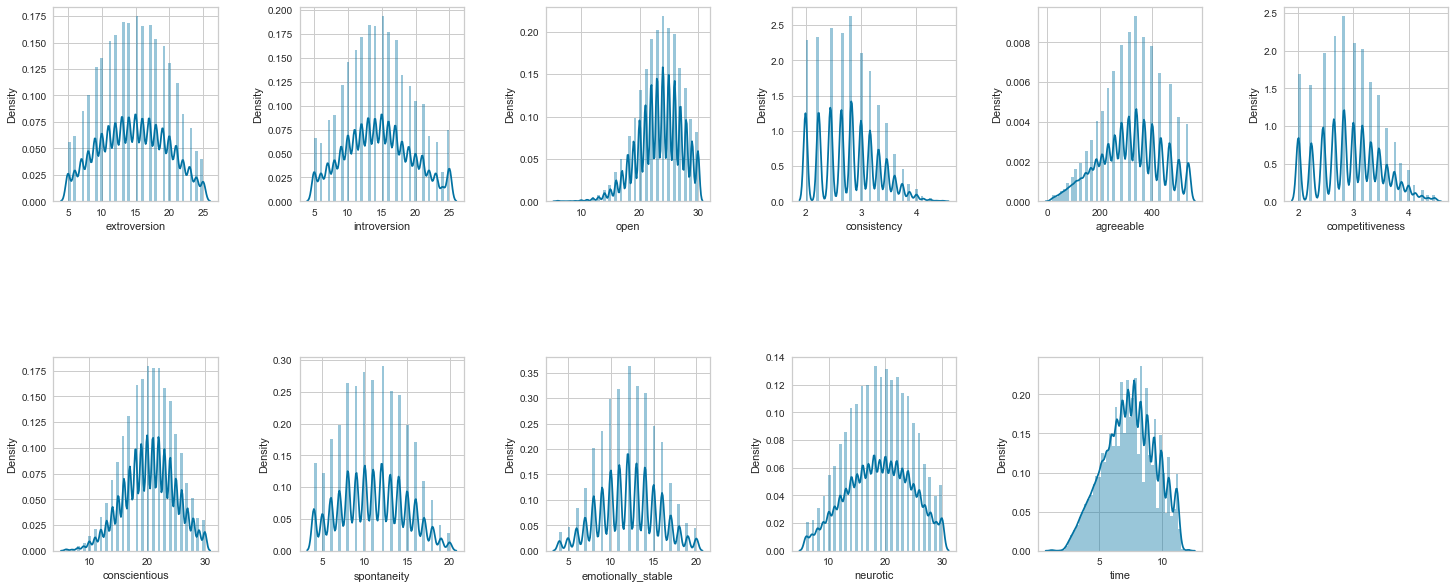

In [ ]:
#@title
a=1
plt.figure(figsize=(25, 10))
for i in df.columns:
    plt.subplot(2, 6, a)
    plt.subplots_adjust(hspace = 0.8,wspace=0.5)
    sns.distplot(df[i])
    a += 1
plt.show()

In [ ]:
df.drop(df.index[df['open'] <= 10 ], inplace = True)

#### 1.3 IQR

In [ ]:
cols = df.columns 

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df_sample = df[0:270000]
df_sample.shape

(270000, 11)

In [ ]:
#@title
# For interpret the results. 
df_ = df_sample.copy()
mm = MinMaxScaler()
for col in df_.columns:
    df_[col] = mm.fit_transform(df_[[col]])
df_.head()

,extroversion,introversion,open,consistency,agreeable,competitiveness,conscientious,spontaneity,emotionally_stable,neurotic,time
0,0.90,0.05,0.6875,0.000000,0.562427,0.335106,0.565217,0.5000,0.6250,0.333333,0.525974
1,0.35,0.75,0.4375,0.547442,0.734948,0.181822,0.652174,0.3125,0.5000,0.291667,0.664828
2,0.35,0.55,0.5000,0.111190,0.562427,0.095492,0.521739,0.3125,0.6250,0.416667,0.513670
3,0.30,0.40,0.5000,0.304154,0.562427,0.404508,0.304348,0.5625,0.5000,0.458333,0.511372
5,0.55,0.40,0.6250,0.000000,0.459830,0.261212,0.608696,0.2500,0.6875,0.291667,0.430608


In [ ]:
ss = StandardScaler()
for col in df_sample.columns:
    df_sample[col] = ss.fit_transform(df_sample[[col]])
df_sample.head()

,extroversion,introversion,open,consistency,agreeable,competitiveness,conscientious,spontaneity,emotionally_stable,neurotic,time
0,1.679159,-1.760798,0.468849,-1.649265,-0.022253,-0.255054,-0.074742,0.232093,0.545119,-0.884332,-0.047447
1,-0.561903,1.069574,-0.653933,0.672872,0.740767,-0.926080,0.383504,-0.558831,-0.045891,-1.062073,0.677628
2,-0.561903,0.260896,-0.373237,-1.177620,-0.022253,-1.304009,-0.303864,-0.558831,0.545119,-0.528852,-0.111696
3,-0.765636,-0.345612,-0.373237,-0.359106,-0.022253,0.048769,-1.449478,0.495735,-0.045891,-0.351111,-0.123696
5,0.253029,-0.345612,0.188153,-1.649265,-0.476017,-0.578538,0.154381,-0.822472,0.840624,-1.062073,-0.545432


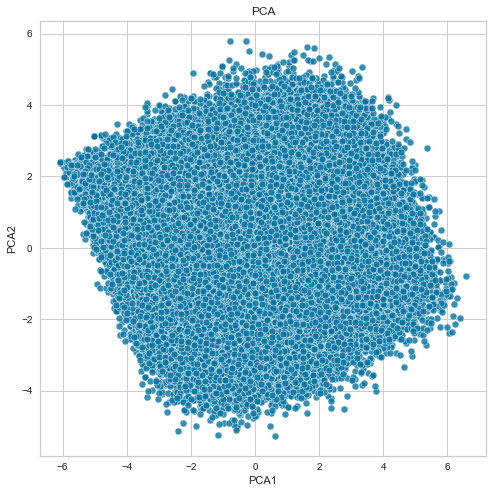

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(df_sample)
df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2',  palette='Set2', alpha=0.8)
plt.title('PCA');

#### 1.5 PCA

In [ ]:
pca = PCA(n_components=1)
pca = pd.DataFrame(pca.fit_transform(df_sample))

### 2. Model

### GMM Bic Aic

In [ ]:
#@title
range_n_clusters = np.arange(2,60,4)
bic = []
aic = []
for num_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=num_clusters)
    gmm.fit(pca)
    b = gmm.bic(pca)
    bic.append(b)
    a = gmm.aic(pca)
    aic.append(a)

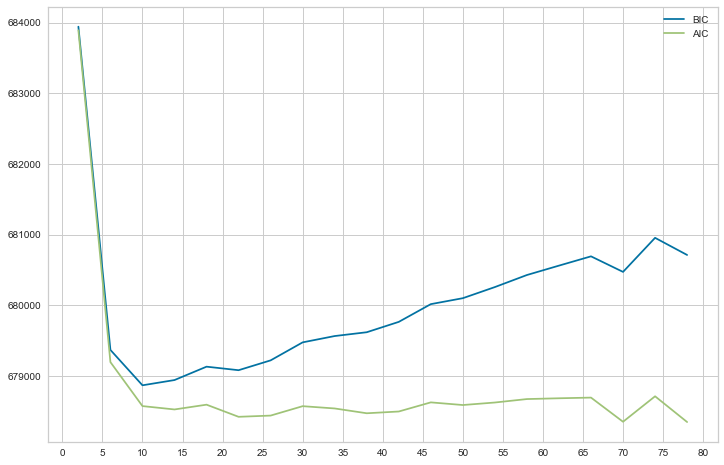

In [ ]:
#@title
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(12,8))
plt.plot(range_n_clusters, bic, label='BIC')
plt.plot(range_n_clusters, aic, label='AIC')
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

### 2.1 K Means

In [ ]:
#@title
range_n_clusters = np.arange(2,15,1)
silhouette =[]
for num_clusters in range_n_clusters:

    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(pca)
    
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(pca, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For k means n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For k means n_clusters=2, the silhouette score is 0.57625017154583
For k means n_clusters=3, the silhouette score is 0.5519243216221391
For k means n_clusters=4, the silhouette score is 0.54011421331695
For k means n_clusters=5, the silhouette score is 0.534965693951442
For k means n_clusters=6, the silhouette score is 0.5312707674213807
For k means n_clusters=7, the silhouette score is 0.5286444422333672
For k means n_clusters=8, the silhouette score is 0.5280361110330829
For k means n_clusters=9, the silhouette score is 0.5262055424031519
For k means n_clusters=10, the silhouette score is 0.5239414626836829
For k means n_clusters=11, the silhouette score is 0.5233836188476315
For k means n_clusters=12, the silhouette score is 0.5221995553104871
For k means n_clusters=13, the silhouette score is 0.5220999051942697
For k means n_clusters=14, the silhouette score is 0.5217865497679789


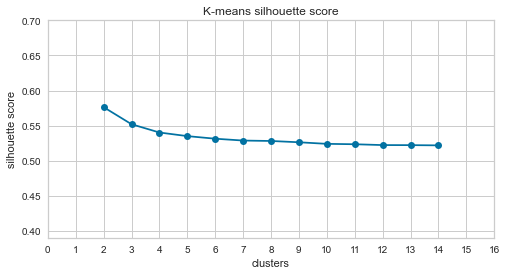

In [ ]:
#@title
ax = plt.axes()
ax.plot(range_n_clusters, silhouette,"-o")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set(xlim=(0, 16), ylim=(0.39, 0.7),
       xlabel='clusters', ylabel='silhouette score',
       title='K-means silhouette score');

### 2.2 GMM

In [ ]:
gmm = GaussianMixture(n_components=10,covariance_type='full')
gmm.fit(pca)
labels = gmm.predict(pca)

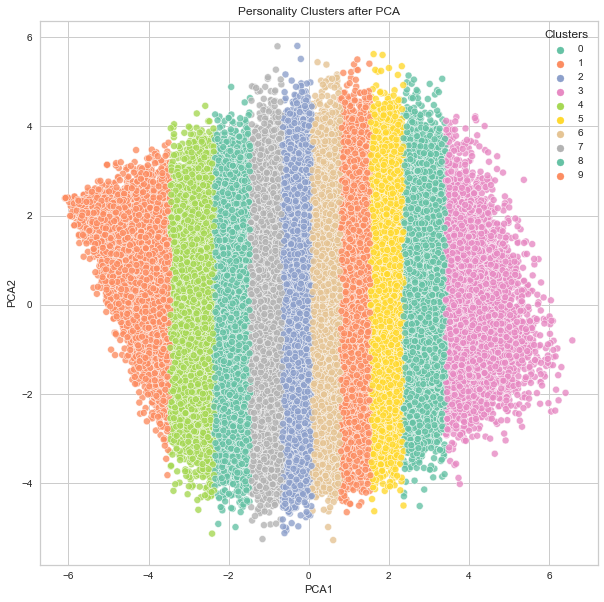

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(df_sample)
df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['Clusters'] = labels
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Clusters', palette='Set2', alpha=0.8)
plt.title('Personality Clusters after PCA');

#### 3. Results

In [ ]:
pd.set_option('display.max_columns', 500)
question = df_.merge(question_df, left_index=True, right_index=True)
question.drop(question.columns[0:10], axis=1, inplace=True)
question['clusters'] = labels
groupby_question = question.groupby('clusters').mean().round(2)
groupby_question.drop(['time'],axis=1,inplace= True)
groupby_question

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.14,2.22,3.99,2.67,4.01,1.82,3.49,3.16,3.41,3.05,3.06,3.44,3.80,2.88,3.40,3.41,2.79,2.37,2.70,2.41,1.67,4.56,1.83,4.59,1.66,4.27,1.50,4.26,4.45,4.24,3.56,2.90,4.22,2.32,2.87,2.62,3.85,2.17,3.42,3.85,2.03,1.81,4.27,1.79,4.10,1.59,4.30,3.34,4.32,4.27
1,2.24,3.28,2.78,3.60,2.77,2.88,2.24,3.68,2.69,4.04,3.47,3.07,3.97,2.56,2.96,2.92,3.29,2.94,3.39,3.14,2.65,3.45,2.58,3.61,2.68,3.49,2.66,3.35,3.45,3.21,3.13,3.08,3.87,2.92,2.38,3.06,3.62,2.77,2.94,3.45,2.40,2.25,3.96,2.17,3.63,2.05,3.89,3.17,4.09,3.78
2,2.70,2.77,3.37,3.18,3.39,2.36,2.83,3.44,3.05,3.63,3.31,3.25,3.93,2.68,3.13,3.11,3.10,2.71,3.09,2.82,2.14,4.05,2.23,4.15,2.14,3.89,2.05,3.83,4.00,3.71,3.33,3.04,4.04,2.68,2.59,2.90,3.70,2.53,3.17,3.64,2.24,2.07,4.09,2.00,3.84,1.85,4.06,3.23,4.20,4.01
3,1.40,4.18,1.62,4.38,1.61,3.99,1.30,4.30,1.75,4.67,3.97,2.55,4.14,2.20,2.62,2.37,3.77,3.54,4.10,3.83,3.68,2.10,3.46,2.14,4.00,2.48,4.07,2.20,2.02,2.14,2.61,3.35,3.57,3.57,1.87,3.57,3.46,3.35,2.40,2.97,2.66,2.68,3.73,2.61,3.15,2.49,3.60,3.05,3.89,3.31
4,3.42,1.91,4.37,2.33,4.39,1.53,3.93,2.97,3.66,2.61,2.85,3.60,3.66,3.06,3.63,3.64,2.54,2.11,2.41,2.10,1.45,4.78,1.61,4.77,1.42,4.47,1.24,4.53,4.65,4.54,3.73,2.74,4.35,2.06,3.11,2.41,3.96,1.92,3.62,4.01,1.91,1.67,4.35,1.67,4.27,1.48,4.43,3.40,4.39,4.45
5,2.00,3.52,2.48,3.79,2.44,3.13,1.95,3.81,2.48,4.20,3.56,2.97,3.97,2.50,2.89,2.83,3.38,3.05,3.55,3.27,2.92,3.09,2.80,3.23,3.00,3.23,3.03,3.05,3.06,2.94,3.02,3.11,3.79,3.03,2.28,3.14,3.57,2.90,2.81,3.35,2.46,2.34,3.90,2.26,3.52,2.16,3.83,3.14,4.03,3.67
6,2.47,3.03,3.09,3.40,3.07,2.62,2.52,3.55,2.88,3.85,3.38,3.18,3.94,2.61,3.04,3.02,3.19,2.83,3.23,2.98,2.39,3.77,2.40,3.91,2.39,3.69,2.34,3.60,3.74,3.46,3.23,3.06,3.94,2.80,2.48,2.98,3.65,2.64,3.05,3.53,2.33,2.15,4.02,2.08,3.73,1.94,3.98,3.19,4.14,3.89
7,2.92,2.48,3.67,2.94,3.69,2.09,3.15,3.29,3.23,3.35,3.20,3.33,3.88,2.76,3.24,3.24,2.96,2.56,2.91,2.63,1.90,4.31,2.04,4.37,1.90,4.07,1.78,4.03,4.23,3.96,3.44,2.99,4.12,2.52,2.71,2.78,3.77,2.35,3.29,3.74,2.14,1.94,4.18,1.90,3.96,1.71,4.17,3.28,4.25,4.14
8,1.69,3.85,2.09,4.07,2.06,3.48,1.61,4.04,2.16,4.45,3.70,2.83,4.03,2.38,2.79,2.68,3.48,3.20,3.76,3.49,3.23,2.65,3.05,2.77,3.42,2.91,3.49,2.71,2.59,2.62,2.88,3.16,3.73,3.20,2.13,3.23,3.54,3.06,2.64,3.25,2.51,2.42,3.83,2.36,3.41,2.27,3.77,3.14,4.00,3.54


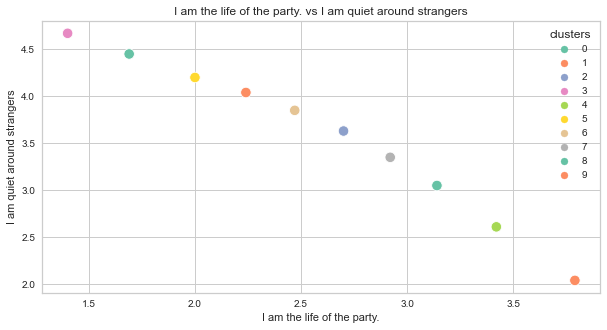

In [ ]:
#@title
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'EXT1',y = 'EXT10', data = groupby_question, hue = 'clusters',palette='Set2',s= 110)
plt.title("I am the life of the party. vs I am quiet around strangers")
plt.xlabel("I am the life of the party.")
plt.ylabel("I am quiet around strangers")
plt.show()
pd.set_option('display.max_columns', 500)

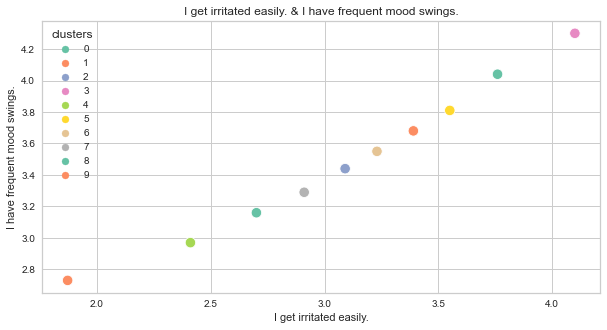

In [ ]:
#@title
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'EST9',y = 'EXT8', data = groupby_question, hue = 'clusters',palette='Set2',s= 110)
plt.title("I get irritated easily. & I have frequent mood swings.")
plt.xlabel("I get irritated easily.")
plt.ylabel("I have frequent mood swings.")
plt.show()
pd.set_option('display.max_columns', 500)

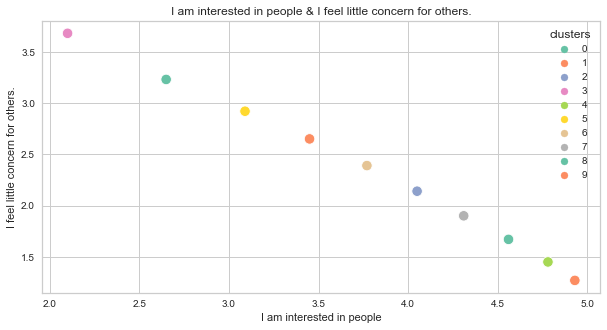

In [ ]:
#@title
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'AGR2',y = 'AGR1', data = groupby_question, hue = 'clusters',palette='Set2',s= 110)
plt.title("I am interested in people & I feel little concern for others.")
plt.xlabel("I am interested in people")
plt.ylabel("I feel little concern for others.")
plt.show()
pd.set_option('display.max_columns', 500)

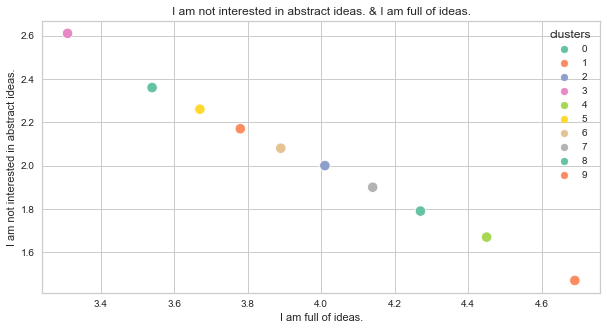

In [ ]:
#@title
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'OPN10',y = 'OPN4', data = groupby_question, hue = 'clusters',palette='Set2',s= 110)
plt.title("I am not interested in abstract ideas. & I am full of ideas.")
plt.xlabel("I am full of ideas.")
plt.ylabel("I am not interested in abstract ideas.")
plt.show()
pd.set_option('display.max_columns', 500)

In [ ]:
#@title
df_['clusters'] = labels
mean_cluster = df_.groupby('clusters').mean()
mean_cluster = mean_cluster.div(mean_cluster.sum(axis=1), axis=0).mul(100).round(2)
with_time =  mean_cluster.copy()
mean_cluster.drop(['time'],axis=1,inplace= True)
mean_cluster

,extroversion,introversion,open,consistency,agreeable,competitiveness,conscientious,spontaneity,emotionally_stable,neurotic
clusters,,,,,,,,,,
0,11.46,5.79,11.64,5.37,13.43,3.91,11.30,6.61,10.03,8.15
1,7.14,10.77,9.82,8.16,8.32,9.14,9.95,9.04,8.66,10.93
2,9.27,8.34,10.58,6.90,10.87,6.50,10.51,8.01,9.16,9.69
3,2.59,15.66,8.14,10.83,3.18,14.71,8.30,11.89,6.93,13.98
4,12.84,4.27,12.27,4.55,14.77,2.57,11.94,5.57,10.80,7.01
5,5.98,12.03,9.51,8.82,6.84,10.67,9.65,9.62,8.46,11.60
6,8.22,9.58,10.20,7.53,9.62,7.77,10.20,8.51,8.94,10.29
7,10.38,7.06,11.09,6.15,12.10,5.24,10.87,7.39,9.52,9.00
8,4.42,13.71,9.20,9.47,5.17,12.47,9.29,10.34,8.00,12.48


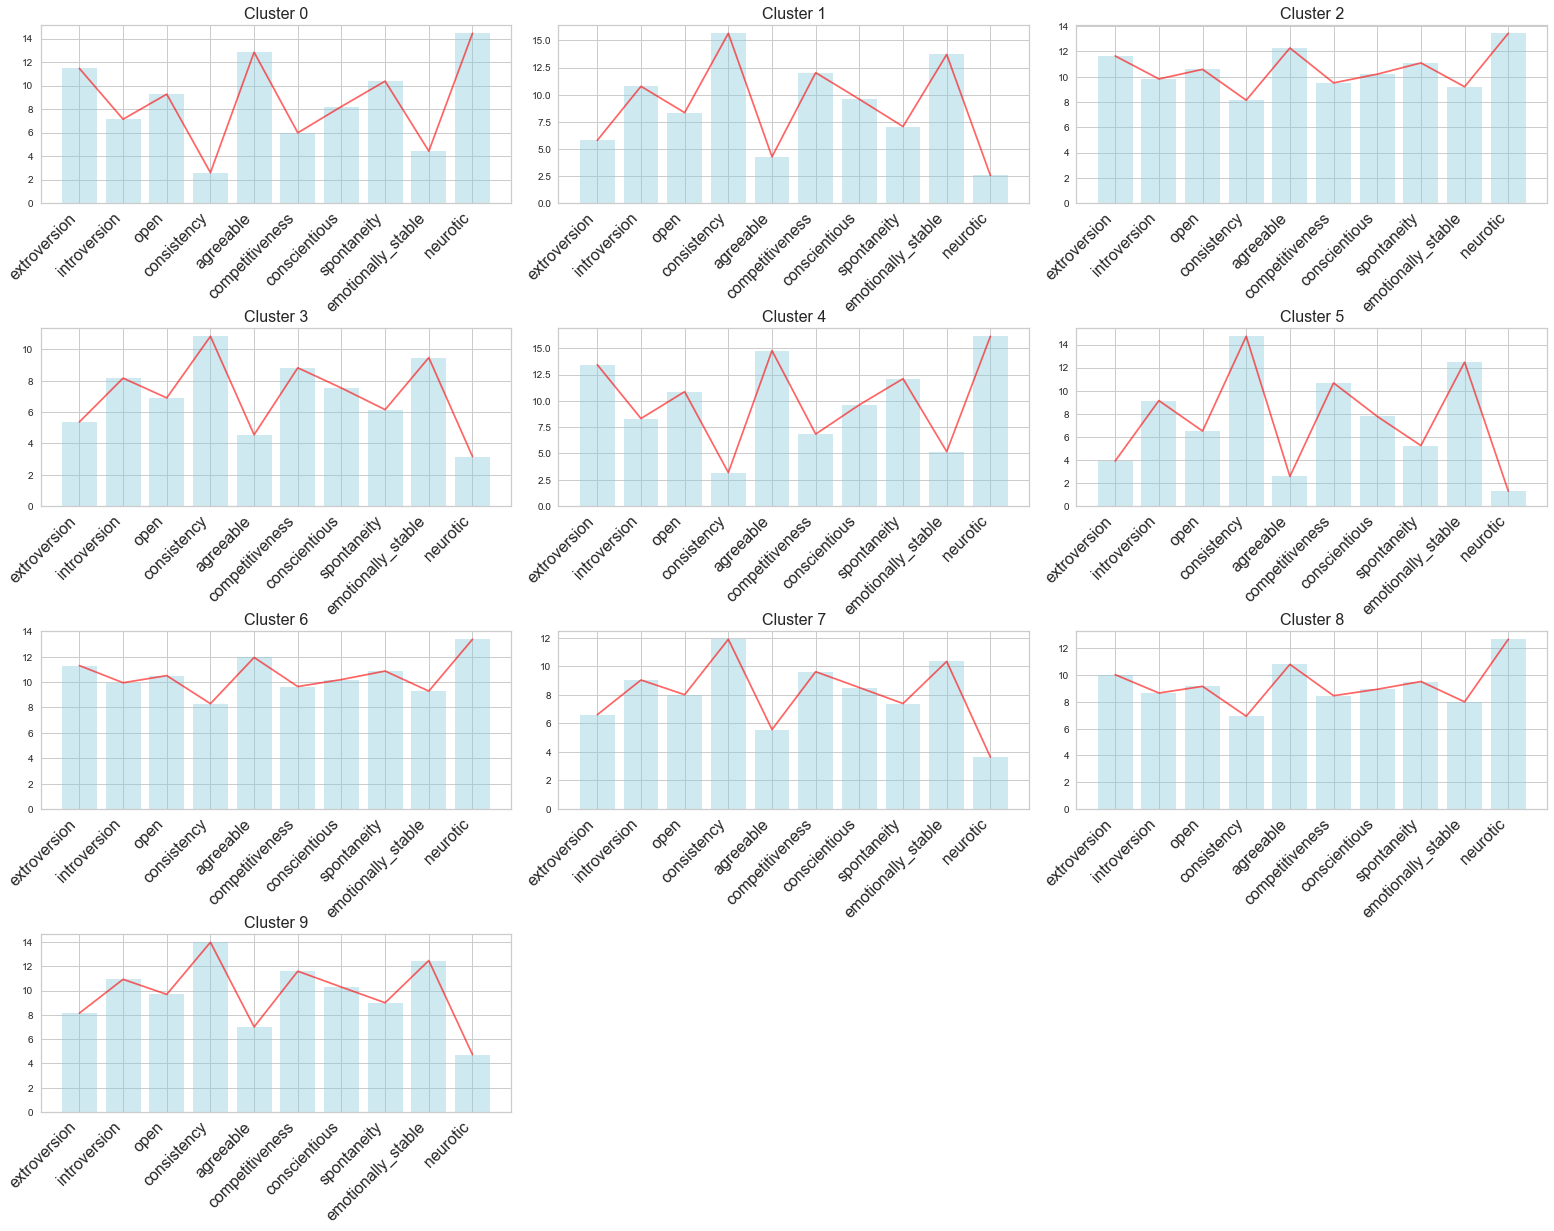

In [ ]:
#@title
a=1
plt.figure(figsize=(27, 20))
c = '#7eb34e'
for i in range(0,10):
    plt.subplot(4, 3, a)
    plt.subplots_adjust(hspace = 0.7,wspace=0.1)
    plt.bar(mean_cluster.columns, mean_cluster.iloc[:, i], color='c', alpha=0.4)
    plt.plot(mean_cluster.columns, mean_cluster.iloc[:, i], color='red',alpha=0.6)
    plt.title('Cluster ' + str(i),fontsize=16)
    plt.xticks(rotation=45,fontsize=16,ha = 'right')

    a += 1
plt.show()

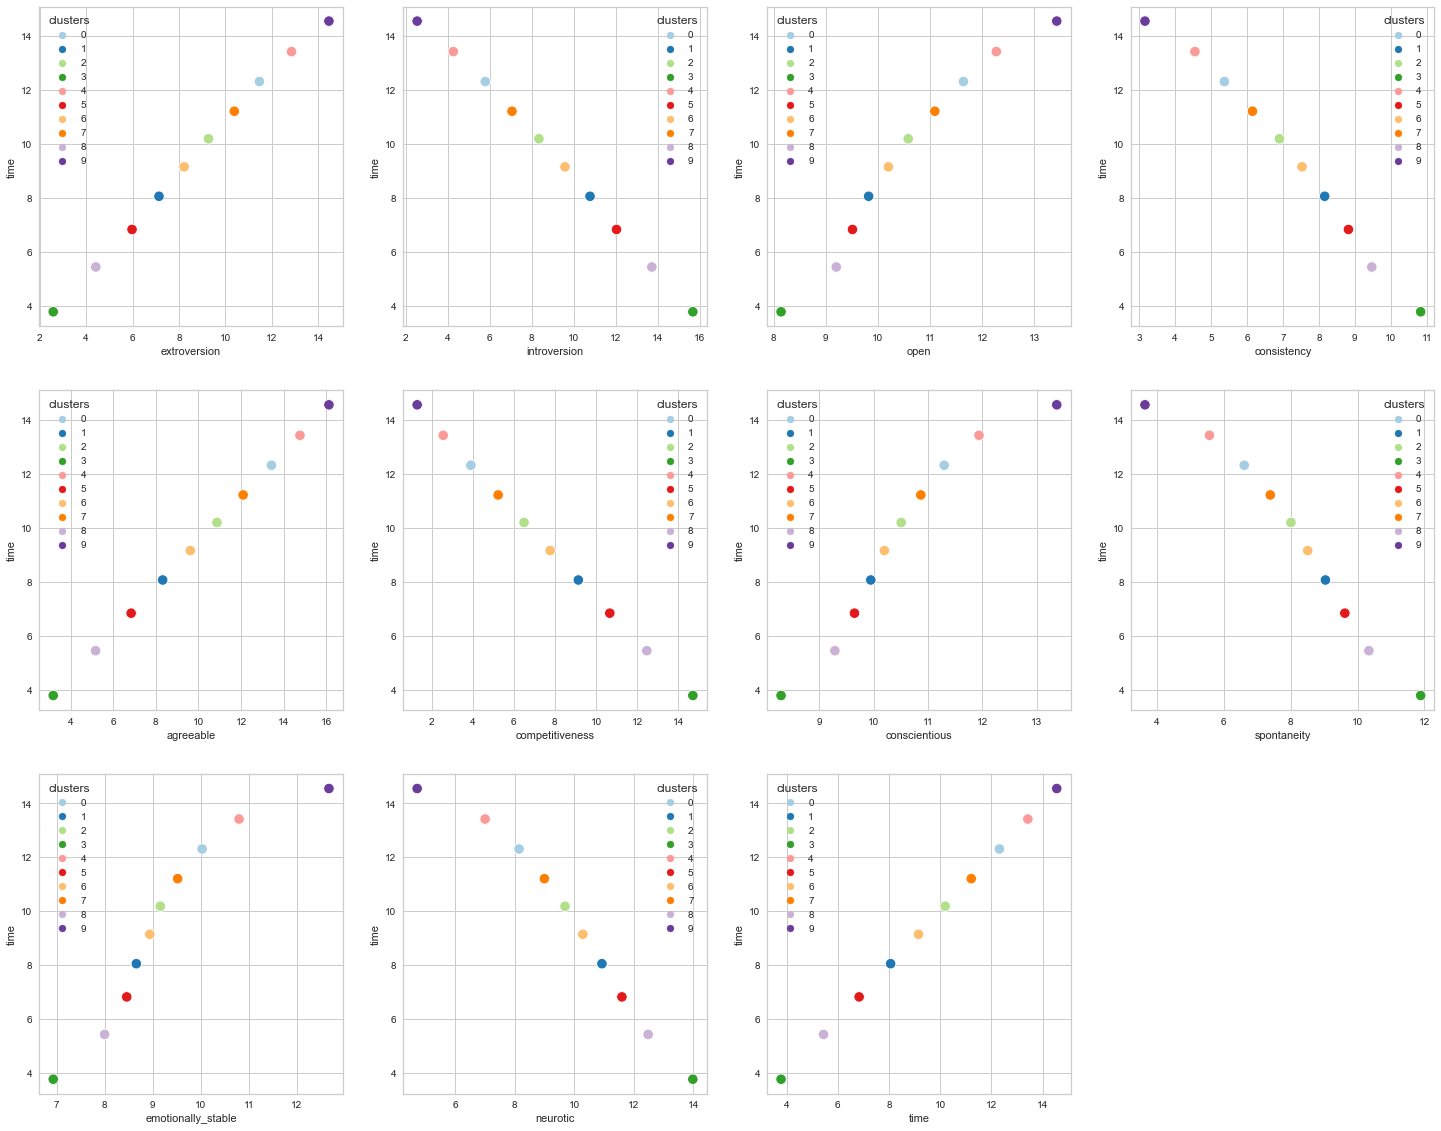

In [ ]:
a=1
plt.figure(figsize=(25, 20))
for i in with_time.columns:
    plt.subplot(3, 4, a)
    plt.subplots_adjust(hspace = 0.2,wspace=0.2)
    sns.scatterplot(x = with_time[i] ,y = 'time', data = with_time, hue = 'clusters',palette='Paired',s= 110)
    a += 1
plt.show()